<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/11.DCGAN/EX_BS2_project11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 라이브러리 버전 확인

In [1]:
# !pip uninstall tensorflow
# !pip uninstall keras
# !pip install tensorflow==2.6.0
# !pip install keras==2.6.0

## STEP 1. 데이터셋 구성하기


In [2]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화


In [4]:
train_x = (train_x - 127.5) / 127.5

- 로드한 학습 데이터를 시각화를 통해 확인


In [5]:
train_x.max(), train_x.min()

(1.0, -1.0)

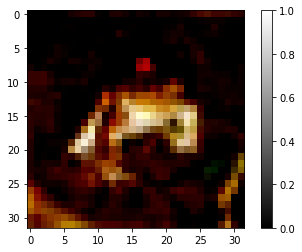

In [6]:
plt.imshow(train_x[0].reshape(32,32,3), cmap='gray')
plt.colorbar()
plt.show()

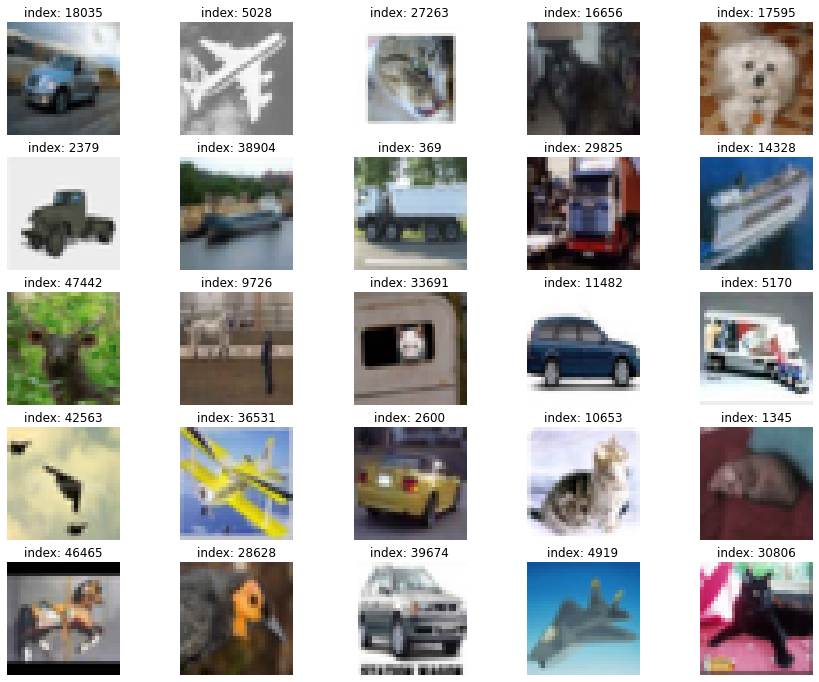

In [7]:
plt.figure(figsize=(15,12))

for i in range(25):
  plt.subplot(5, 5, i+1)
  a = np.random.randint(1,50000)
  #plt.imshow(train_x[a].reshape(32,32,3), cmap='gray')
  Image = np.clip(train_x[a], 0, 1)
  plt.imshow((train_x[a] + 1)/2.0)
  plt.title(f'index: {a}')
  plt.axis('off')

plt.show()

- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성


데이터를 잘 섞기 위해 buffer_size는 훈련 데이터 전체 크기로 설정

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

shuffle() 함수로 섞고 batch_size만큼 train_dataset에 넣어줌

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)>

## STEP 2. 생성자 모델 구현하기


In [11]:
def make_generator_model():

  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Reshape((8,8,256)))
  # model.add(layers.Dropout(0.5))


  model.add(layers.Conv2DTranspose(512, kernel_size=(4,4), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.5))

  model.add(layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.5))

  model.add(layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.5))  

  model.add(layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.5))  

  # model.add(layers.Conv2D(64, kernel_size=(4,4), strides=(2,2) ,padding='same', use_bias=False))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU(alpha=0.2))

  model.add(layers.Conv2D(3, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  return model

  

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2097152   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성


In [13]:
noise = tf.random.normal([1,100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

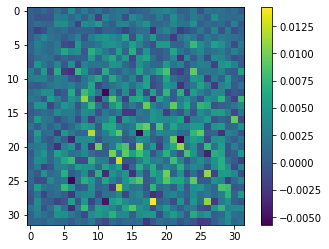

In [15]:
plt.imshow(generated_image[0,:,:,0])
plt.colorbar()
plt.show()

# Step 3. 판별자 모델 구현하기

In [16]:
def make_discriminator_model():

  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same', input_shape=[32,32,3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  

  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))

  # model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
  # # model.add(layers.BatchNormalization())  
  # model.add(layers.LeakyReLU(alpha=0.2))
  # model.add(layers.Dropout(0.5))

  model.add(layers.Conv2D(256, (3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization())  
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Flatten())

  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                      

- 위에서 noise를 이용해 생성한 이미지를 판별해봄

In [18]:
decision = discriminator(generated_image, training=False)

decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50002766]], dtype=float32)>

## Step 4. 손실함수와 최적화함수 구현하기

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- 생성자 loss 함수 구현

In [20]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

- 판별자 loss 함수 구현

In [21]:
def discriminator_loss(real_output, fake_output):
  #real_output은 1에 가까워지게, fake_output은 0에 가까워지게 만들고 싶음
  #real_output은 ones_like와 cross_entropy, fake_output은 zeros_like와 cross_entropy
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

- 판별자 accuracy 함수 구현

In [22]:
def discriminator_accuracy(real_output, fake_output):
  real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
  fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
  return real_accuracy, fake_accuracy

- optimizer 구현

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

- 학습 확인을 위한 고정된 seed noise 만들어줌

In [24]:
noise_dim = 100
num_examples_to_generator = 16

seed = tf.random.normal([num_examples_to_generator, noise_dim])
seed.shape


TensorShape([16, 100])

## Step 5. 훈련과정 상세 기능 구현

- train_step() 함수 구현

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


- generate_and_save_images 함수 구현

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

- draw_train_history 함수 구현

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

- check point 모듈 설정

In [28]:
checkpoint_dir = '/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/training_checkpoints/'

checkpoint_prefix = (checkpoint_dir+'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 6. 학습 시키기

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 100

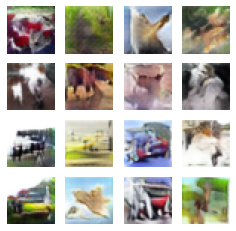

Time for training : 10112 sec


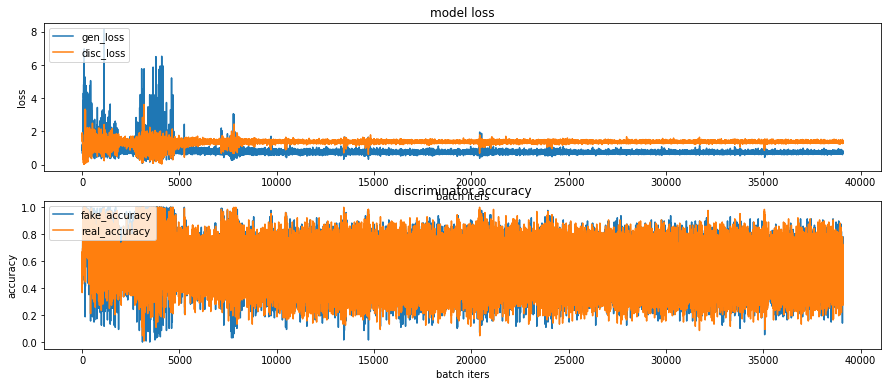

CPU times: user 2h 48min 25s, sys: 51.3 s, total: 2h 49min 17s
Wall time: 2h 48min 35s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

- gif 로 시각화

In [32]:
#sample gif
anim_file = '/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/fifth.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.7)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [33]:
# history gif
anim_file_2 = '/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/fifth_history.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/AIFFEL/EX/11. 세상에 없던 패션 만들기(DCGAN)/training_history/train*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.8)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
